In [1]:
import re
from collections import Counter
from nltk.stem import WordNetLemmatizer
import seaborn as sns


# Load and preprocess the dataset
# Assuming `corpus` is a list of documents, each document being a string

# Custom stopword list
stopwords = set(["the", "is", "in", "and", "to", "from", "a", "for", "of", "on", "at", "with", "as", "by", "an", "it", "this", "that", "which", "be", "or", "are", "we", "can", "was", "but", "has", "have", "not", "if", "they", "their", "will", "do", "my", "all", "about"])

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords, then lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords]
    return words

# Example corpus (replace this with your 20 Newsgroups data)
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Preprocess each document
preprocessed_corpus = [preprocess(doc) for doc in corpus]
print("Preprocessed Corpus:", preprocessed_corpus)


Preprocessed Corpus: [['first', 'document'], ['document', 'second', 'document'], ['third', 'one'], ['first', 'document']]


In [2]:
# Get all unique terms across the corpus
vocab = sorted(set(word for doc in preprocessed_corpus for word in doc))
vocab_to_index = {word: idx for idx, word in enumerate(vocab)}

# Initialize the DTM matrix
dtm = [[0] * len(vocab) for _ in range(len(preprocessed_corpus))]

# Populate the DTM
for doc_idx, doc in enumerate(preprocessed_corpus):
    word_counts = Counter(doc)
    for word, count in word_counts.items():
        dtm[doc_idx][vocab_to_index[word]] = count

print("Document-Term Matrix:")
for row in dtm:
    print(row)


Document-Term Matrix:
[1, 1, 0, 0, 0]
[2, 0, 0, 1, 0]
[0, 0, 1, 0, 1]
[1, 1, 0, 0, 0]


In [3]:
import numpy as np

# Convert DTM to a numpy array
dtm = np.array(dtm)

# Calculate SVD (from scratch approximation)
def svd_from_scratch(matrix, num_components):
    # Step 1: Compute matrix * matrix.T and matrix.T * matrix
    M = np.dot(matrix, matrix.T)
    N = np.dot(matrix.T, matrix)
    
    # Step 2: Eigen decomposition of M and N
    eigvals_u, U = np.linalg.eigh(M)
    eigvals_v, V = np.linalg.eigh(N)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx_u = np.argsort(eigvals_u)[::-1][:num_components]
    idx_v = np.argsort(eigvals_v)[::-1][:num_components]
    
    U = U[:, idx_u]
    V = V[:, idx_v]
    
    # Step 3: Compute singular values (sqrt of top eigenvalues)
    singular_values = np.sqrt(eigvals_u[idx_u])
    
    return U, singular_values, V.T




In [4]:
# Choose number of components
num_components = 3
U, S, Vt = svd_from_scratch(dtm, num_components)

# Document-Topic Matrix (U * S)
document_topic_matrix = U * S[:num_components]
print("Document-Topic Matrix:\n", document_topic_matrix)

# Topic-Word Matrix (Vt)
topic_word_matrix = Vt[:num_components, :]
print("Topic-Word Matrix:\n", topic_word_matrix)

Document-Topic Matrix:
 [[-1.23378806e+00  5.82867088e-16 -6.91206939e-01]
 [-2.08034021e+00 -9.99200722e-16  8.19868656e-01]
 [-7.53617870e-17 -1.41421356e+00 -1.13315649e-15]
 [-1.23378806e+00  9.99200722e-16 -6.91206939e-01]]
Topic-Word Matrix:
 [[-0.89907808 -0.33470998  0.         -0.28218405  0.        ]
 [ 0.          0.          0.70710678  0.          0.70710678]
 [-0.1580884   0.84929533  0.         -0.50369186  0.        ]]


In [5]:
# Normalize rows to get probabilities
document_topic_probs = document_topic_matrix / document_topic_matrix.sum(axis=1, keepdims=True)
topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

print("Document-Topic Probabilities:\n", document_topic_probs)
print("Topic-Word Probabilities:\n", topic_word_probs)


Document-Topic Probabilities:
 [[ 6.40930527e-01 -3.02788885e-16  3.59069473e-01]
 [ 1.65044598e+00  7.92719771e-16 -6.50445980e-01]
 [ 5.32888306e-17  1.00000000e+00  8.01262638e-16]
 [ 6.40930527e-01 -5.19066660e-16  3.59069473e-01]]
Topic-Word Probabilities:
 [[ 0.59307033  0.22078901 -0.          0.18614066 -0.        ]
 [ 0.          0.          0.5         0.          0.5       ]
 [-0.84307033  4.52921099  0.         -2.68614066  0.        ]]


In [7]:
Vt.shape

(3, 5)

In [8]:
U[0]

array([-4.54401349e-01,  4.12149270e-16, -5.41774320e-01])

In [11]:
U

array([[-4.54401349e-01,  4.12149270e-16, -5.41774320e-01],
       [-7.66184591e-01, -7.06541606e-16,  6.42620551e-01],
       [-2.77555756e-17, -1.00000000e+00, -8.88178420e-16],
       [-4.54401349e-01,  7.06541606e-16, -5.41774320e-01]])

In [13]:
S

array([2.71519453, 1.41421356, 1.27582079])

In [10]:

print("U           - ",U.shape)
print("Sigma       - ",S.shape)
print("V_transpose - ",Vt.shape)

U           -  (4, 3)
Sigma       -  (3,)
V_transpose -  (3, 5)


<Axes: >

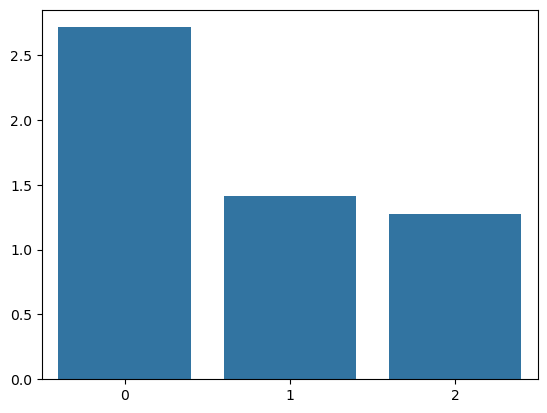

In [14]:
sns.barplot(x=list(range(len(S))), y = S)

In [11]:
# Choose number of components
num_components = 4
U, S, Vt = svd_from_scratch(dtm, num_components)

# Document-Topic Matrix (U * S)
document_topic_matrix = U * S[:num_components]
print("Document-Topic Matrix:\n", document_topic_matrix)

# Topic-Word Matrix (Vt)
topic_word_matrix = Vt[:num_components, :]
print("Topic-Word Matrix:\n", topic_word_matrix)

Document-Topic Matrix:
 [[-1.23378806e+00  5.82867088e-16 -6.91206939e-01             nan]
 [-2.08034021e+00 -9.99200722e-16  8.19868656e-01             nan]
 [-7.53617870e-17 -1.41421356e+00 -1.13315649e-15             nan]
 [-1.23378806e+00  9.99200722e-16 -6.91206939e-01             nan]]
Topic-Word Matrix:
 [[-0.89907808 -0.33470998  0.         -0.28218405  0.        ]
 [ 0.          0.          0.70710678  0.          0.70710678]
 [-0.1580884   0.84929533  0.         -0.50369186  0.        ]
 [-0.         -0.          0.70710678  0.         -0.70710678]]


C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\3926595217.py:24: RuntimeWarning: invalid value encountered in sqrt
  singular_values = np.sqrt(eigvals_u[idx_u])


In [12]:
# Normalize rows to get probabilities
document_topic_probs = document_topic_matrix / document_topic_matrix.sum(axis=1, keepdims=True)
topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

print("Document-Topic Probabilities:\n", document_topic_probs)
print("Topic-Word Probabilities:\n", topic_word_probs)


Document-Topic Probabilities:
 [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
Topic-Word Probabilities:
 [[ 0.59307033  0.22078901 -0.          0.18614066 -0.        ]
 [ 0.          0.          0.5         0.          0.5       ]
 [-0.84307033  4.52921099  0.         -2.68614066  0.        ]
 [        nan         nan         inf         nan        -inf]]


C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\1756369894.py:3: RuntimeWarning: divide by zero encountered in divide
  topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)
C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\1756369894.py:3: RuntimeWarning: invalid value encountered in divide
  topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)


In [13]:
# Choose number of components
num_components = 5
U, S, Vt = svd_from_scratch(dtm, num_components)

# Document-Topic Matrix (U * S)
document_topic_matrix = U * S[:num_components]
print("Document-Topic Matrix:\n", document_topic_matrix)

# Topic-Word Matrix (Vt)
topic_word_matrix = Vt[:num_components, :]
print("Topic-Word Matrix:\n", topic_word_matrix)

Document-Topic Matrix:
 [[-1.23378806e+00  5.82867088e-16 -6.91206939e-01             nan]
 [-2.08034021e+00 -9.99200722e-16  8.19868656e-01             nan]
 [-7.53617870e-17 -1.41421356e+00 -1.13315649e-15             nan]
 [-1.23378806e+00  9.99200722e-16 -6.91206939e-01             nan]]
Topic-Word Matrix:
 [[-0.89907808 -0.33470998  0.         -0.28218405  0.        ]
 [ 0.          0.          0.70710678  0.          0.70710678]
 [-0.1580884   0.84929533  0.         -0.50369186  0.        ]
 [-0.         -0.          0.70710678  0.         -0.70710678]
 [-0.40824829  0.40824829  0.          0.81649658  0.        ]]


C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\3926595217.py:24: RuntimeWarning: invalid value encountered in sqrt
  singular_values = np.sqrt(eigvals_u[idx_u])


In [14]:
# Normalize rows to get probabilities
document_topic_probs = document_topic_matrix / document_topic_matrix.sum(axis=1, keepdims=True)
topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

print("Document-Topic Probabilities:\n", document_topic_probs)
print("Topic-Word Probabilities:\n", topic_word_probs)


Document-Topic Probabilities:
 [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
Topic-Word Probabilities:
 [[ 0.59307033  0.22078901 -0.          0.18614066 -0.        ]
 [ 0.          0.          0.5         0.          0.5       ]
 [-0.84307033  4.52921099  0.         -2.68614066  0.        ]
 [        nan         nan         inf         nan        -inf]
 [-0.5         0.5         0.          1.          0.        ]]


C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\1756369894.py:3: RuntimeWarning: divide by zero encountered in divide
  topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)
C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_18276\1756369894.py:3: RuntimeWarning: invalid value encountered in divide
  topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)



Lemmatization is the process of reducing words to their base or root form, known as the "lemma." It considers the meaning and context of the word, unlike stemming, which simply chops off word endings. For instance, lemmatization would reduce words like "running," "ran," and "runs" to their base form, "run," and "better" to "good," if those are their root forms.

Lemmatization is especially useful in natural language processing because it ensures that words with similar meanings are treated as the same word, which can improve the quality of text analysis and topic modeling.